In [1]:
%%capture
!pip install -qq scikit-learn==1.7.2

In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
#%load_ext cudf.pandas
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.impute import SimpleImputer

from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

%matplotlib inline
plt.style.use('seaborn-v0_8')
plt.rc('figure', figsize=(10,6), dpi=180)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=15, titlepad=10)
plt.rc('animation', html='html5')


import warnings
warnings.simplefilter('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e10/sample_submission.csv
/kaggle/input/playground-series-s5e10/train.csv
/kaggle/input/playground-series-s5e10/test.csv
/kaggle/input/simulated-roads-accident-data/synthetic_road_accidents_10k.csv
/kaggle/input/simulated-roads-accident-data/synthetic_road_accidents_2k.csv
/kaggle/input/simulated-roads-accident-data/synthetic_road_accidents_100k.csv


In [46]:
train = pd.read_csv('/kaggle/input/playground-series-s5e10/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv', index_col='id')

In [47]:
org = []
for n in [2, 10, 100]:
    df = pd.read_csv(f'/kaggle/input/simulated-roads-accident-data/synthetic_road_accidents_{n}k.csv')
    org.append(df)

org = pd.concat(org, axis=0)
org.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,rural,2,0.72,60,daylight,clear,True,False,afternoon,False,False,2,0.37
1,highway,4,0.95,45,daylight,foggy,False,True,evening,False,True,1,0.40
2,rural,1,0.72,25,night,rainy,False,False,evening,True,False,1,0.55
3,rural,4,0.86,70,dim,foggy,True,False,morning,True,True,1,0.56
4,highway,1,0.00,60,night,rainy,True,True,morning,True,True,3,0.54


In [48]:
train = pd.concat([train, org], axis=0, ignore_index=True)

In [13]:
train.columns

Index(['road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting',
       'weather', 'road_signs_present', 'public_road', 'time_of_day',
       'holiday', 'school_season', 'num_reported_accidents', 'accident_risk'],
      dtype='object')

In [92]:
print(f'Check any duplicate values')
print(train.duplicated().sum())

Check any duplicate values
695


In [5]:
train = train.drop_duplicates()
train.duplicated().sum()

0

In [49]:
target = 'accident_risk'
base = ['road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting',
       'weather', 'road_signs_present', 'public_road', 'time_of_day',
       'holiday', 'school_season', 'num_reported_accidents']
cats = ['road_type', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season']

In [ ]:
train.info()

# Feature Engineering

In [50]:
meta = []

for df in [train, test]:
    base_risk = (
        0.3 * df["curvature"] + 
        0.2 * (df["lighting"] == "night").astype(int) + 
        0.1 * (df["weather"] != "clear").astype(int) + 
        0.2 * (df["speed_limit"] >= 60).astype(int) + 
        0.1 * (np.array(df["num_reported_accidents"]) > 2).astype(int)
    )
    
    noise = np.random.normal(0, 0.05, df.shape[0])
    risk_score = np.clip(base_risk + noise, 0, 1)
    df["simulated_risk"] = np.round(risk_score, 2).astype('float32')

meta.append('simulated_risk')

In [51]:
inter = []
for df in [train, test]:
    df['speed_visibility'] = df['speed_limit'] * df['lighting'].map({'daylight': 0.5, 'dim': 1.0, 'night': 1.5}).fillna(1.0)
    df['curv_speed'] = df['curvature'] * df['speed_limit'] 
    df['curv_sq'] = df['curvature']**2
    df['speed_sq'] = df['speed_limit']**2
    df['curv_per_lane'] = df['curvature'] / (df['num_lanes'] + 1)
    df['risk_density'] = df['curv_speed'] / (df['num_lanes'] + 1)
    df['curve_night_risk'] = df['curvature'] * (df['lighting'] == 'night').astype(int)
    df['curv_log'] = np.log1p(df['curvature'])
    df['speed_log'] = np.log1p(df['speed_limit'])
    
new_cols = ['speed_visibility', 'curv_speed', 'curv_sq', 'speed_sq', 'curv_per_lane', 
            'risk_density', 'curve_night_risk', 'curv_log', 'speed_log']

inter.extend(new_cols)

print(inter)


['speed_visibility', 'curv_speed', 'curv_sq', 'speed_sq', 'curv_per_lane', 'risk_density', 'curve_night_risk', 'curv_log', 'speed_log']


In [52]:
features = base + inter + meta

In [23]:
train.shape

(517754, 34)

In [154]:
test.shape

(172585, 33)

## Splitting the data into training and testing sets


In [53]:
X = train[features]
y = train[target]

In [54]:
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

oof_xgb = np.zeros(len(y))
test_xgb = np.zeros(len(test))

In [55]:
params = {
    'n_estimators': 100000,
    'learning_rate': 0.01,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse',
    'random_state':42, 
    'early_stopping_rounds': 200,
    'device': 'cuda',
    'objective': 'reg:squarederror',
    'enable_categorical': True,
}

In [56]:
from sklearn.preprocessing import TargetEncoder
from sklearn.metrics import root_mean_squared_error

In [58]:
for fold, (train_index, valid_index) in enumerate(kf.split(X, y), start=1):
    print(f'---Fold {fold}/{n_folds}---')
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    X_test = test[features].copy()

    for col in cats:
        TE = TargetEncoder(cv=5, smooth='auto', random_state=2)
        X_train[col] = TE.fit_transform(X_train[[col]], y_train)
        X_valid[col] = TE.transform(X_valid[[col]])
        X_test[col] = TE.transform(X_test[[col]])
    
    xgb = XGBRegressor(**params).fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)

    valid_pred = xgb.predict(X_valid)
    oof_xgb[valid_index] = valid_pred
    test_xgb += xgb.predict(X_test)
    
    fold_rmsle = np.sqrt(mean_squared_error(y_valid, valid_pred))
    print(f"Fold {fold} RMSE: {fold_rmsle:.6f}")

test_xgb /= n_folds
overall_rmsle = np.sqrt(mean_squared_error(y, oof_xgb))
overall_r2score = r2_score(y, oof_xgb)
overall_explained_var = explained_variance_score(y, oof_xgb)

print(f"\nOverall OOF RMSE: {overall_rmsle:.6f}")  
print(f"\nOverall OOF R2Score: {overall_r2score:.6f}")  
print(f"\nOverall OOF Explained Variance: {overall_explained_var:.6f}")  

---Fold 1/5---
Fold 1 RMSE: 0.056383
---Fold 2/5---
Fold 2 RMSE: 0.056219
---Fold 3/5---
Fold 3 RMSE: 0.055906
---Fold 4/5---
Fold 4 RMSE: 0.055805
---Fold 5/5---
Fold 5 RMSE: 0.055977

Overall OOF RMSE: 0.056059

Overall OOF R2Score: 0.890143

Overall OOF Explained Variance: 0.890143


<function matplotlib.pyplot.show(close=None, block=None)>

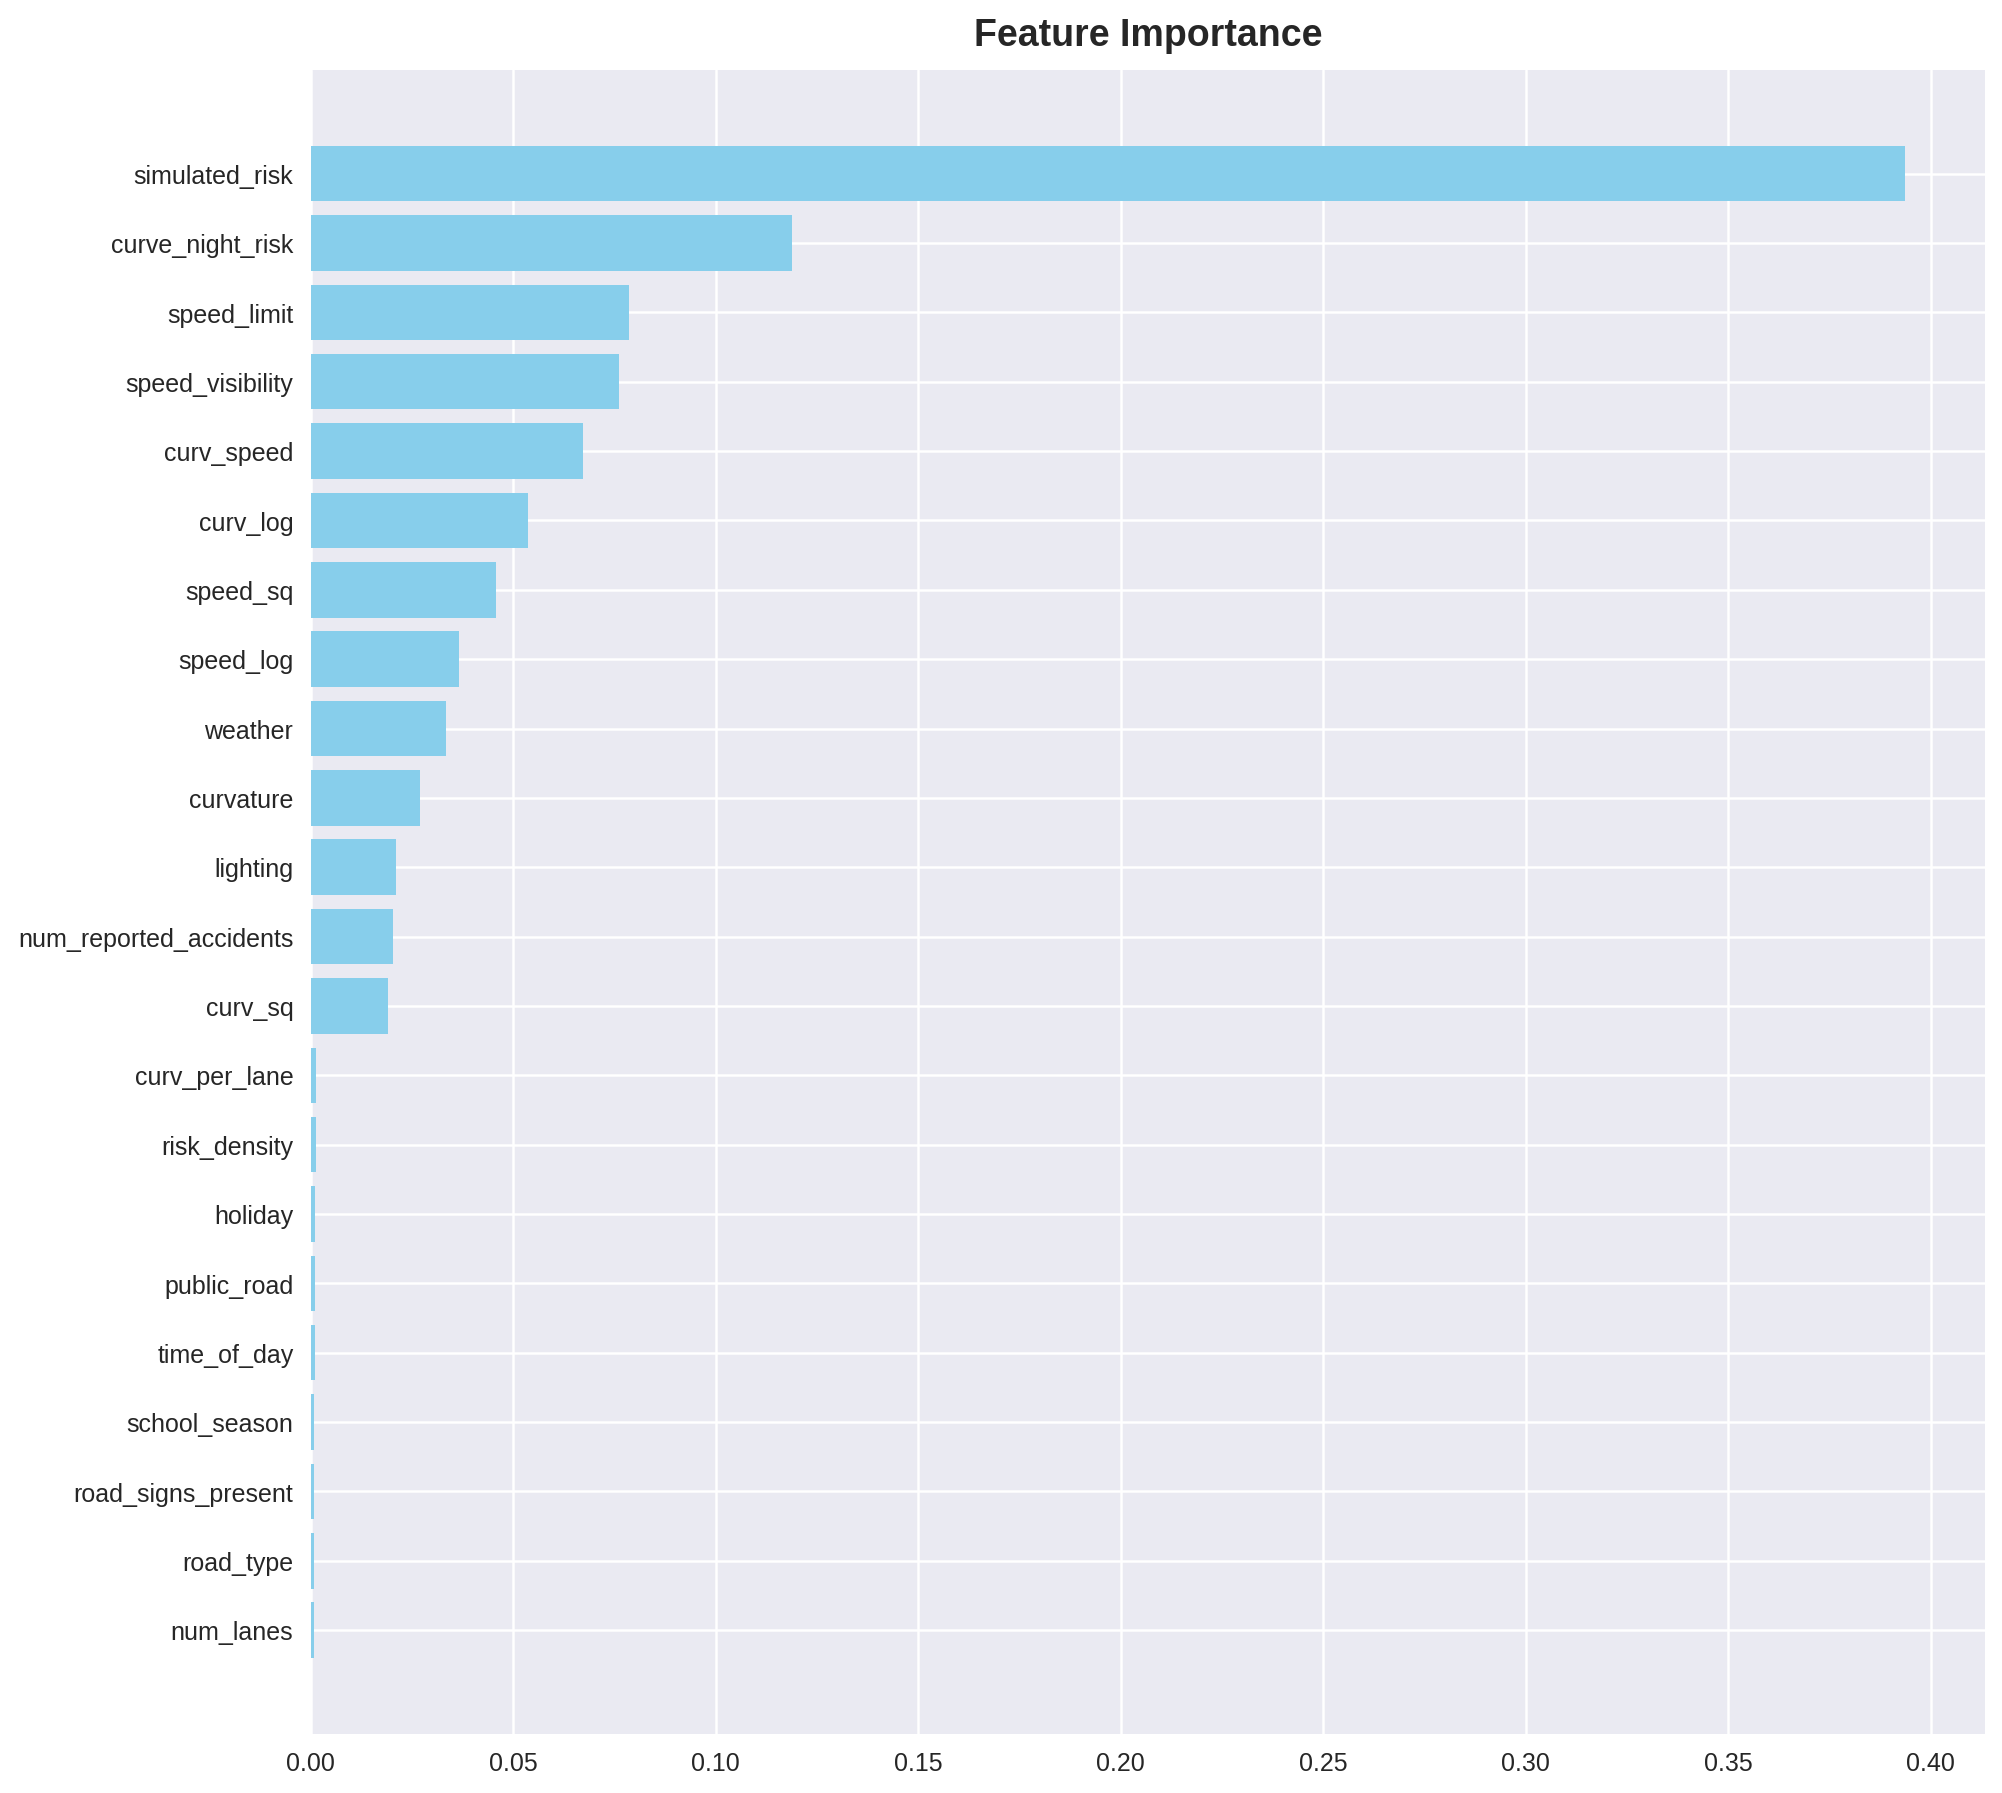

In [59]:
importances = xgb.feature_importances_
columns = X.columns

df_importances = pd.DataFrame({'Feature': columns, 'Importance': importances})
df_importances = df_importances.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 12))
plt.barh(df_importances['Feature'], df_importances['Importance'], color='skyblue')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show

In [60]:
import pickle

# Save model
with open("xgb_model.pkl", "wb") as f:
    pickle.dump(xgb, f)

In [61]:
sub = pd.read_csv('/kaggle/input/playground-series-s5e10/sample_submission.csv')
sub['accident_risk'] = test_xgb
sub.to_csv('submission.csv', index=False)
sub.head()

,id,accident_risk
0,517754,0.295546
1,517755,0.120160
2,517756,0.182057
3,517757,0.338461
4,517758,0.387389
